# Latency
Latency is the delay introduced by an algorithm or limitations in computational complexity.
The latency is described in the following by the simple example of linear time invariant (LTI) filter.
LTI filter can be described by their impulse response $h(n)$. The output of the filter can be described by the convolution:

$y(n) = h(n)*x(n)$ .

The underlying signal model of the latency is: The output signal $y(n)$ is approximately described by the input signal $x(n)$ delayed by a delay / latency $T$:

$y(n)\approx x\left(n-T\right)$ .

In [2]:
import numpy as np
import matplotlib.pyplot as plt

r = 48000
fc = 3000

## IIR lowpass
In the following, a simple lowpass is defined by the equation:

$y(n)=a\cdot y(n-1) + (1-a)\cdot x(n)$ .

The corresponding impulse response is:

$h(n)=(1-a)\cdot a^n$ .

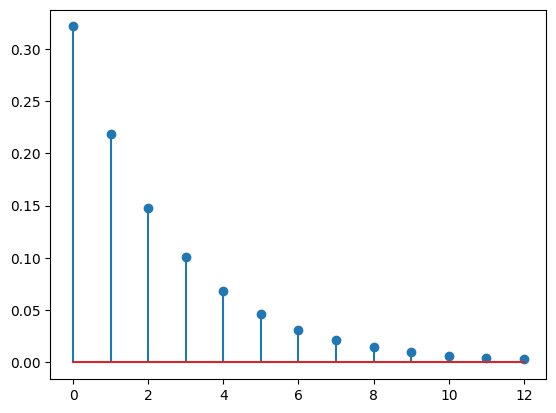

In [3]:
def CutoffFrequency2DampingParameter(fc, r):
    assert fc > 0, 'cutoff frequency must be greater 0'
    assert 2*fc < r, 'cutoff frequency must be smaller r/2'
    p = 2*np.cos(2*np.pi*fc/r)-4
    return -p/2 - np.sqrt((p/2)**2-1)

def GetIIRImpulseResponse(a = CutoffFrequency2DampingParameter(fc, r)):
    LengthUntilVanishes = int(-5 / np.log(a)) + 1
    h = np.zeros(LengthUntilVanishes)
    h[0] = 1-a
    for n in range(1, h.shape[0]):
        h[n] = a * h[n-1]
    return h

h_IIR = GetIIRImpulseResponse()
plt.stem(h_IIR)
plt.show()

## FIR lowpass

Additionally, a FIR lowpass is defined in order to show the differences between IIR filters and FIR filters regarding the delays.

In [1]:
def GetFIRImpulseResponse(fc, r):
    assert fc < r/2, 'violation of sampling theorem'
    NumberOfZeroCrossings = 3
    LengthOfFilterInSamples = NumberOfZeroCrossings*r/fc-1
    n = np.arange(LengthOfFilterInSamples) - np.floor(LengthOfFilterInSamples / 2)
    t = n / r
    h_LP = np.sinc(2 * fc * t)
    w = 0.5 * (1 + np.cos(np.pi * n / LengthOfFilterInSamples)) # Hann-Window
    h = w * h_LP
    return h

h_FIR = GetFIRImpulseResponse(fc, r)
plt.stem(h_FIR)
plt.show()

NameError: name 'fc' is not defined

## Latency estimation by Maximum-method
The simplest way of defining the latency of a filter is the Maximum-Method:

Assuming a filter $h(n)$ has its maximum absolute amplitude at the position $n_\text{max}$.

In this case, the delay is defined by $T=n_\text{max}$.

In [6]:
def EvaluateDelayByMaximumMethod(h):
    DelayInSamples = np.argmax(np.abs(h))
    DelayInMilliseconds = DelayInSamples *1000 / r
    print('delay in samples = ', int(DelayInSamples))
    print('delay in milliseconds = ', DelayInMilliseconds)

print('Maximum method - IIR')
EvaluateDelayByMaximumMethod(h_IIR)
print('Maximum method - FIR')
EvaluateDelayByMaximumMethod(h_FIR)

Maximum method - IIR
delay in samples =  0
delay in milliseconds =  0.0
Maximum method - FIR
delay in samples =  23
delay in milliseconds =  0.4791666666666667


## Latency estimation by Center-of-mass-method

Generally, a more precise methode for estimating the delay of a filter defined by the impulse response $h(n)$ is the center of mass.
For a time-continuous impulse response $h(t)$ the center of mass is defined by:

$T = \frac{\int_{-\infty}^\infty t\cdot \left|h(t)\right|}{\int_{-\infty}^\infty \left|h(t)\right|}$ .

For a time-discrete impulse response $h(n)$ the center of mass is definde by:

$T = \frac{\sum_n n\cdot \left|h(n)\right|}{\sum_n \left|h(n)\right|}$ .

In [7]:
def EvaluateDelayByCenterOfMassMethod(h):
    n_vector = np.arange(h.shape[0])
    DelayInSamples = np.sum(n_vector*np.abs(h)) / np.sum(np.abs(h))
    DelayInMilliseconds = DelayInSamples *1000 / r
    print('delay in samples = ', int(np.round(DelayInSamples)))
    print('delay in milliseconds = ', DelayInMilliseconds)

print('Center of mass method - IIR')
EvaluateDelayByCenterOfMassMethod(h_IIR)
print('Center of mass method - FIR')
EvaluateDelayByCenterOfMassMethod(h_FIR)

Center of mass method - IIR
delay in samples =  2
delay in milliseconds =  0.04222054415108061
Center of mass method - FIR
delay in samples =  23
delay in milliseconds =  0.4791666666666665


## Latency measurement

The latency introduced by an impulse response can be measured by comparison of input and output signals:

In [8]:
def EvaluateCrossCorrelation(x, y):
    fftlen = np.maximum(x.shape[0], y.shape[0]) * 2
    phi = np.fft.ifft(np.fft.fft(y, fftlen) * np.conj(np.fft.fft(x, fftlen))).real
    return phi

def EstimateDelay(x, y):
    phi = EvaluateCrossCorrelation(x, y)
    T = np.argmax(np.abs(phi[0:(phi.shape[0]//2)]))
    return T

# test latency evaluation
MaxIter = 20
for T in range(MaxIter):
    x = np.random.randn(MaxIter*4)    
    if T > 0:
        y = np.zeros(x.shape)
        y[T:] = x[0:-T]
    else:
        y = np.copy(x)
    assert np.abs(T - EstimateDelay(x, y)) < 1e-2, 'error in delay evaluation'

def EvaluateDelayByMeasurement(h):
    x = np.random.randn(10*h.shape[0])
    y = np.convolve(x, h)
    DelayInSamples = EstimateDelay(x, y)
    DelayInMilliseconds = DelayInSamples *1000 / r
    print('delay in samples = ', int(DelayInSamples))
    print('delay in milliseconds = ', DelayInMilliseconds)

print('Measurement method - IIR')
EvaluateDelayByCenterOfMassMethod(h_IIR)
print('Measurement method - FIR')
EvaluateDelayByCenterOfMassMethod(h_FIR)

Measurement method - IIR
delay in samples =  2
delay in milliseconds =  0.04222054415108061
Measurement method - FIR
delay in samples =  23
delay in milliseconds =  0.4791666666666665


## Programming Exercise
Another approach to evaluate the latency of an impulse response is the phase delay:

$T=-\frac{\varphi(f)}{2\pi f}$

1) Implement the procedure EvaluateFourierTransform based on the z-Transform.
2) Implement the procedure TransferFunction2Phase, which evaluates the phase (or the angle) $\varphi(f)$ of the complex transfer function $H$. Keep in mind, that the phase is periodical with $2\pi$. In order to evaluate the correct phase delay, the phase must be unwrapped (the $2\pi$-periodicity must be inverted).
3) Implement the procedure PhaseDelay according to the function $T(f)=-\frac{\varphi(f)}{2\pi f}$. In order to avoid a division by zero, the delay $T$ for frequency $f=0$ should be defined as $T(f=0) = 0$.

In [9]:
import unittest

f = np.arange(r//2)

def EvaluateFourierTransform(h, f):
    H = np.zeros(f.shape, dtype = complex)
    ### solution begins
    for n in range(h.shape[0]):
        H += h[n] * np.exp(-1j*2*np.pi*f*n/r)
    ### solution ends
    return H

def TransferFunction2Phase(H):
    ### solution begins
    angle = np.unwrap(np.angle(H))
    ### solution ends
    return angle

def PhaseDelay(H, f):
    ### solution begins
    T = np.zeros(f.shape)
    mask = np.abs(f) > 1e-16
    T[mask] = -TransferFunction2Phase(H[mask]) / (2*np.pi*f[mask])
    ### solution ends
    return T

class TestProgrammingExercise(unittest.TestCase):

    def test_EvaluateFourierTransform(self):
        H = EvaluateFourierTransform(h_FIR, f)
        H_abs = np.abs(H)
        fc_index = np.argmin(np.abs(f - fc))
        self.assertGreater(np.amin(H_abs[:fc_index]), H_abs[fc_index])
        self.assertLess(np.amax(H_abs[fc_index+1:]), H_abs[fc_index])
        self.assertAlmostEqual(H[42], 8.1750 - 1.0393j, delta = 1e-2)

    def test_TransferFunction2Phase1(self):
        h = np.random.randn(99)
        h += np.flip(h)
        for n in range(h.shape[0]):
            self.assertAlmostEqual(h[n], h[h.shape[0]-1-n], delta = 1e-2)
        H = EvaluateFourierTransform(h, f)
        angle = TransferFunction2Phase(H*np.exp(1j*2*np.pi*f*(h.shape[0]//2)/r))
        Testpattern = np.sin(np.diff(angle))
        self.assertAlmostEqual(np.amax(Testpattern), 0.0, delta = 1e-2)
        self.assertAlmostEqual(np.amin(Testpattern), 0.0, delta = 1e-2)

    def test_TransferFunction2Phase2(self):
        H = EvaluateFourierTransform(h_FIR, f)
        angle = TransferFunction2Phase(H)
        nc = np.argmin(np.abs(fc - f))
        Dangle = np.diff(angle)
        self.assertAlmostEqual(np.amax(Dangle[:nc]), np.amin(Dangle[:nc]), delta = 1e-10)

    def test_TransferFunction2Phase3(self):
        H = EvaluateFourierTransform(h_FIR, f)
        angle = TransferFunction2Phase(H)
        self.assertGreater(-2*np.pi, np.amin(angle))
    
    def test_PhaseDelay(self):
        H = EvaluateFourierTransform(h_FIR, f)
        T = PhaseDelay(H, f)
        fc_index = np.argmin(np.abs(f - fc))
        T_True = (h_FIR.shape[0] // 2) / r
        self.assertAlmostEqual(np.amax(T[1:fc_index-1]), T_True, delta = 1e-2)
        self.assertAlmostEqual(np.amin(T[1:fc_index-1]), T_True, delta = 1e-2)   

    def test_PhaseDelayDC(self):
        T = PhaseDelay(H = np.ones((1)), f = np.zeros((1)))
        self.assertAlmostEqual(T, 0.0, delta = 1e-15)
    
# https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
unittest.main(argv=[''], verbosity=2, exit=False)

test_EvaluateFourierTransform (__main__.TestProgrammingExercise.test_EvaluateFourierTransform) ... ok
test_PhaseDelay (__main__.TestProgrammingExercise.test_PhaseDelay) ... ok
test_PhaseDelayDC (__main__.TestProgrammingExercise.test_PhaseDelayDC) ... ok
test_TransferFunction2Phase1 (__main__.TestProgrammingExercise.test_TransferFunction2Phase1) ... ok
test_TransferFunction2Phase2 (__main__.TestProgrammingExercise.test_TransferFunction2Phase2) ... ok
test_TransferFunction2Phase3 (__main__.TestProgrammingExercise.test_TransferFunction2Phase3) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.860s

OK


## Exam preparation

1) What is the meaning of the abbreviation LTI?

2) A speaker has a distance of $20$ m to the listener. Evaluate the latency of the voice transmission through the air. Assume a sound of speed of $343$ m/s.

3) Evaluate the latency/delay in milliseconds of a FIR lowpass filter with length $N=501$ samples for a sampling rate of $r=48$ kHz. For this evaluation, the same procedures as above are assumed, to generate the lowpass filter.

4) A time-continuous impulse response is given: $h(t)=\varepsilon(t)\cdot\frac{1}{\tau}\cdot e^{-t/\tau}$. with the unit step $\varepsilon\left(x\right)$ defined as follows:

$\varepsilon(x) = \begin{cases}
        1 & \text{if } x \geq 0\\
        0 & \text{else}
    \end{cases}$. Evaluate the latency introduced by the given impulse response with the center of mass method. 

5) A time-discrete impulse response is given: $h(n)=[1, 2, 4, 2, 1]$. Evaluate the latency introduced by the given impulse response with the center of mass method.